### PDF model of HSC differentiation on continuum cell state space 
Inputs:
   T: final time 
   ntest: choose single-cell data set 
        = 0 - Nestorowa data / 1 - Paul data 
   nAML : choose AML condition 
        = INF - normal condition / integer number - AML condition at nAML 

###### Load scRNA-seq data 

In [1]:
addpath('data/', 'dimension_reduction/', 'PDE_solver/', 'misc/'); 
filename = 'Nestorowa2016_scRNAseqData.mat'; 
load( filename ); 
ntest = 0;  % test case number for Nestorowa's data 

###### Dimension Reduction 

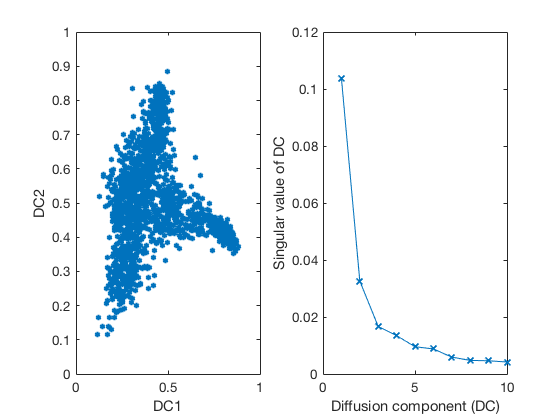

In [2]:
[dc, dcSig] = DiffusionMap_wNewData( scdata', [], 10, 0.5, Inf );
dc = dc_normalize(dc, 10);    % Normalize Diffusion Component to [0 1]
save( filename, 'dc', 'dcSig' ,'-append' ) 
figure; subplot( 1, 2, 1 ); f1=plot( dc(:,1), dc(:,2), 'o', 'markersize', 3); set(f1, 'markerfacecolor', get(f1, 'color'));xlim( [0 1] ); ylim( [0 1]); xlabel('DC1'); ylabel('DC2')
subplot( 1, 2, 2 ); plot( dcSig, '-x' ); xlabel('Diffusion component (DC)'); ylabel('Singular value of DC')

###### PDE grid and differentiation matrix 

In [3]:
global N N1 dx 
N = [100 125]; 
Compute_systemMatrix( N ); 

###### Compute homeostasis distribution 

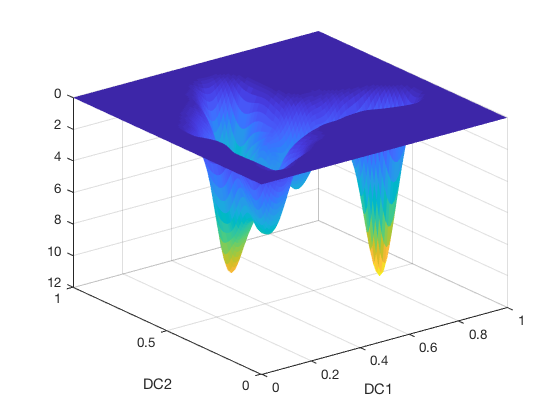

In [4]:
global xx yy 
[YY,XX] = meshgrid(yy,xx); 
[uHS,~,~] = ksdensity( [dc(:,1:2)], [XX(:),YY(:)], 'bandwidth', [0.03 0.03] );
uHS = reshape( uHS, N1(1), N1(2) ); 
figure; surf( XX, YY, uHS, 'linestyle','none' ); set(gca, 'Zdir', 'reverse'); xlabel('DC1'); ylabel('DC2'); 

###### Compute PDE coefficients by Interpolation 

In [6]:
set_system_paramters; 
Compute_systemCoeff( ntest, uHS ); 

###### Solve PDE in Normal condition 

Elapsed time is 24.139425 seconds.



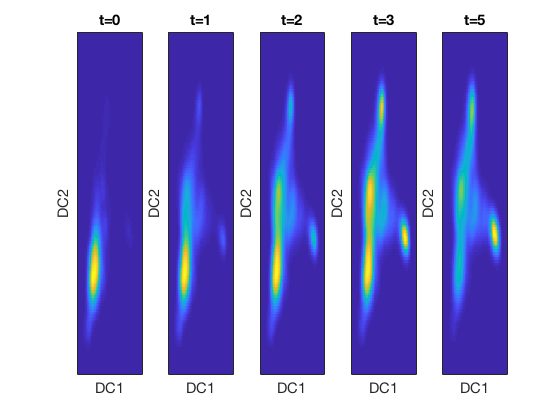

In [8]:
% Set Initial Condition 
uinit = IC_2Dsp( 0.5, uHS*0.05, ntest ); 
uinit = BC_2Dsp( uinit );

% Solve PDE with RK 
T = 5; dt = 0.001; Tstep = 1; 
uPlot = Time_Integ_RK4( @Compute_du_2Dsp, @BC_2Dsp, uinit, T, dt, Tstep ); 

figure; hold on;
for nT = 1:(T/Tstep+1) 
    subplot( 1, 5, min(nT, 5)); 
    imagesc( squeeze(uPlot(:,:,nT))' ); 
    set(gca, 'YDir','normal');  title( strcat( 't=', int2str(nT-1) )); 
    xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 
end

###### Solve PDE in AML condition - 1

Elapsed time is 23.771787 seconds.



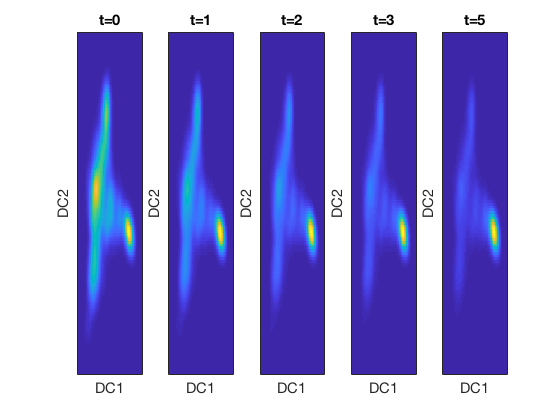

In [9]:
Update_AML( ntest )

%% IC for AML case - initiate from homoestasis
uinit = IC_2Dsp( 0, uHS, ntest ); 
uinit = BC_2Dsp( uinit );

T = 5; dt = 0.001; Tstep = 1;
uPlot = Time_Integ_RK4( @Compute_du_2Dsp, @BC_2Dsp, uinit, T, dt, Tstep ); 

figure; hold on;
for nT = 1:(T/Tstep+1) 
    subplot( 1, 5, min(nT, 5)); 
    imagesc( squeeze(uPlot(:,:,nT))' ); 
    set(gca, 'YDir','normal');  title( strcat( 't=', int2str(nT-1) )); 
    xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 
end


###### Solve PDE in AML condition - 2